In [21]:
import json
import pandas as pd
import matplotlib.pyplot as plt
from ipywidgets import FileUpload
from IPython.display import display
from html import escape
import re

In [22]:
uploader = FileUpload(
    accept='.json',
    multiple=False
)
display(uploader)

FileUpload(value=(), accept='.json', description='Upload')

Полный отчет:


,ID,Критерий,Уровень,Статус,Рекомендации,Подробности
0,1.1.1,Non-text Content,A,FAILED,Add the alt attribute for 1 image(-s). Alt text should briefly and meaningfully describe the content or purpose of the image,"[ { ""src"": ""http://localhost:5500/test.png"", ""selector"": ""img"" } ]"
1,1.2.2,Captions (Prerecorded),A,REVIEW_NEEDED,Video elements must have HTML built-in captions for prerecorded audio content,"[ { ""src"": ""http://localhost:5500/test.mp4"", ""selector"": ""video#video2"" } ]"
2,1.4.3,Contrast (Minimum),AA,PASSED,,All evaluated text elements meet the minimum contrast ratio requirement of 4.5:1
3,1.4.4,Resize Text,AA,FAILED,Text elements must be resizable up to 200 percent without being clipped or overlapping other content,"[ { ""text"": ""Тестовая веб-страница"", ""selector"": ""h1"" }, { ""text"": ""\n This is a long paragraph that will overflow its container when zoomed\n in.\n "", ""selector"": ""p#clipped-text"" } ]"
4,1.4.12,Text Spacing,AA,REVIEW_NEEDED,"Ensure that increasing line height, paragraph spacing, letter spacing, and word spacing does not cause text to be clipped, overlapped, or hidden. Avoid fixed heights and overflow:hidden on text containers","[ { ""text"": ""Тестовая веб-страница"", ""selector"": ""h1"" }, { ""text"": ""\n This is a long paragraph that will overflow its container when zoomed\n in.\n "", ""selector"": ""p#clipped-text"" } ]"
5,2.4.2,Page Titled,A,REVIEW_NEEDED,Ensure the page title is descriptive and clearly identifies the page purpose or content,"{ ""title"": ""Document"" }"
6,2.4.7,Focus Visible,AA,PASSED,,"All focusable elements have a visible focus indicator with proper outline, box-shadow, or border"
7,3.1.1,Language of Page,A,REVIEW_NEEDED,"Review and align HTML lang attribute with actual page content language. Choose correct BCP 47 code: <html lang=""eng""> or adjust content to match existing declaration.","{ ""htmlLanguage"": ""ru"", ""dominantLanguage"": ""eng"" }"
8,3.1.2,Language of Parts,AA,PASSED,,No elements with a lang attribute other than <html> were found


Pivot-таблица по критериям и статусам:


,FAILED,REVIEW_NEEDED,PASSED
Критерий,,,
Non-text Content,x,,
Captions (Prerecorded),,x,
Contrast (Minimum),,,x
Resize Text,x,,
Text Spacing,,x,
Page Titled,,x,
Focus Visible,,,x
Language of Page,,x,
Language of Parts,,,x


Сводка по статусам:


,Статус,Количество проверок
0,FAILED,2
1,PASSED,3
2,REVIEW_NEEDED,4


Сводка по уровням:


,Уровень,Количество проверок
0,A,4
1,AA,5


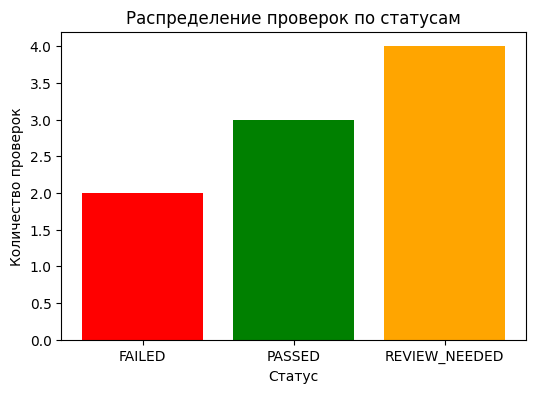

In [26]:
if not uploader.value:
    print("Файл ещё не загружен")
    raise SystemExit

uploaded_file = uploader.value[0]
content = bytes(uploaded_file.content).decode("utf-8")
data = json.loads(content)

rows = []

for check in data["results"]:
    details = check["result"].get("details", "")

    if isinstance(details, (dict, list)):
        details_formatted = json.dumps(
            details,
            ensure_ascii=False,
            indent=2
        )
    else:
        details_formatted = str(details)

    pattern = re.compile(r'<[^<]+?>')
    
    rows.append({
        "ID": check.get("id", ""),
        "Критерий": check["name"],
        "Уровень": check.get("level", ""),
        "Статус": check["result"]["status"],
        "Рекомендации": check["result"].get("recommendations", ""),
        "Подробности": details_formatted
    })

df = pd.DataFrame(rows)

df = df[
    ["ID", "Критерий", "Уровень", "Статус", "Рекомендации", "Подробности"]
]

df['Рекомендации'] = df['Рекомендации'].apply(lambda value : escape(str(value)))

def render_preformatted(text: str) -> str:
    return f"<pre style='white-space: pre-wrap; text-align: left; background: transparent'>{escape(text)}</pre>"

print("Полный отчет:")

styled_df = df.style.format({
    "Подробности": render_preformatted
})

display(styled_df)

def marker(status_cell, column_name):
    return "x" if status_cell == column_name else ""

pivot_columns = df["Статус"].unique()
pivot = pd.DataFrame(index=df["Критерий"], columns=pivot_columns)
for idx, row in df.iterrows():
    for col in pivot_columns:
        pivot.at[row["Критерий"], col] = marker(row["Статус"], col)

print("Pivot-таблица по критериям и статусам:")
display(pivot)

status_summary = (
    df.groupby("Статус")
      .size()
      .reset_index(name="Количество проверок")
)

print("Сводка по статусам:")
display(status_summary)

level_summary = (
    df.groupby("Уровень")
      .size()
      .reset_index(name="Количество проверок")
)

print("Сводка по уровням:")
display(level_summary)

plt.figure(figsize=(6, 4))

colors = {
    "PASSED": "green",
    "REVIEW_NEEDED": "orange",
    "FAILED": "red",
    "ERROR": "gray"
}

plt.bar(
    status_summary["Статус"],
    status_summary["Количество проверок"],
    color=[colors.get(s, "blue") for s in status_summary["Статус"]]
)

plt.title("Распределение проверок по статусам")
plt.xlabel("Статус")
plt.ylabel("Количество проверок")
plt.show()